In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from coffea import hist
from coffea.processor import defaultdict_accumulator

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.CMS)
#hep.CMS.text("Phase 2 Simulation")

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

2023-07-28 11:13:26.420724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 11:13:26.662638: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-28 11:13:26.662694: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-28 11:13:47.304498: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [13]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5'
model_pt_regress_name = '../models/pt_regress_v1_bestest.h5'
model_merge_name = '../models/merged_11_gamma33.h5'

In [14]:
test_index = 400000

In [15]:
MinBias = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root")
MinBias_id = np.asarray(MinBias['ntuplePupSingle']['tree']['event'].array())[test_index:]
MinBias_iso = np.asarray(MinBias['ntuplePupSingle']['tree']['chargedIso'].array())[test_index:]
MinBias_pt = np.asarray(MinBias['ntuplePupSingle']['tree']['pt'].array())[test_index:]
MinBias_inputs = np.nan_to_num(np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array())[test_index:])

n_event = np.unique(MinBias_id).shape[0]

In [21]:
model_id = load_model(model_id_name)
MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_id_merge = load_model(model_merge_name)
MinBias_nn_score_model_merge = model_id_merge.predict(MinBias_inputs)[0]

model_regress = load_model(model_pt_regress_name)
MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

model_merge = load_model(model_merge_name)
MinBias_nn_selected_pt_ratio_merge = model_merge.predict(MinBias_inputs)[1].flatten()

8869/8869 [==============================] - 12s 1ms/step


In [22]:
MinBias_pt_corrected = np.multiply(MinBias_nn_selected_pt_ratio, MinBias_pt)
MinBias_pt_corrected_merge = np.multiply(MinBias_nn_selected_pt_ratio_merge, MinBias_pt)
print(MinBias_pt)
print(MinBias_pt_corrected)
print(MinBias_pt_corrected_merge)

[ 0.   17.   20.5  ... 11.25  0.   19.5 ]
[ 0.       21.07268  24.487371 ... 10.803997  0.       20.96028 ]
[ 0.       21.217989 25.810566 ... 11.139259  0.       19.252485]


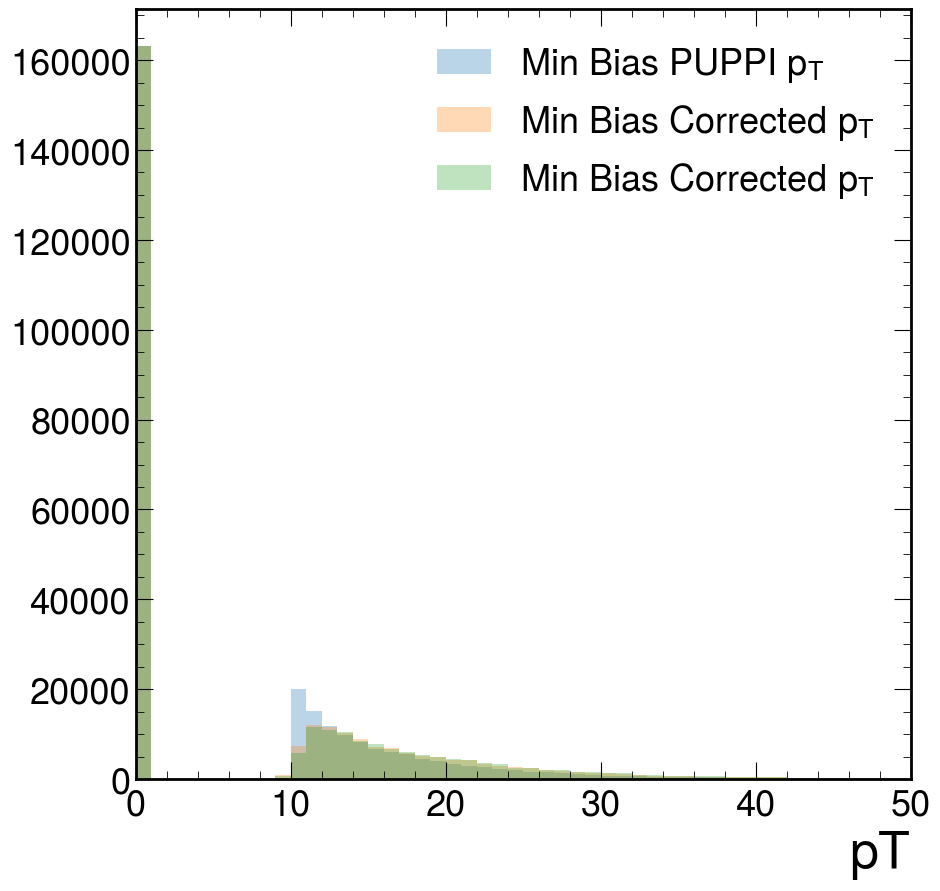

In [23]:
plt.hist(MinBias_pt, range = [0, 100], bins = 100, alpha=0.3, label=r'Min Bias PUPPI $p_T$')
plt.hist(MinBias_pt_corrected, range = [0, 100], bins =100, alpha=0.3, label=r'Min Bias Corrected $p_T$')
plt.hist(MinBias_pt_corrected_merge, range = [0, 100], bins =100, alpha=0.3, label=r'Min Bias Corrected $p_T$')
plt.xlim([0,50])
plt.xlabel(r'$pT$')
plt.legend()

In [24]:
nn_cut = 0.21  #official NN cut point

In [26]:
MinBias_nn_selected_id = MinBias_id[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_id_merge = MinBias_id[MinBias_nn_score_model_merge.flatten() > nn_cut]
MinBias_nn_selected_pt = MinBias_pt[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_pt_corrected = MinBias_pt_corrected[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_pt_corrected_merge = MinBias_pt_corrected_merge[MinBias_nn_score_model_merge.flatten() > nn_cut]

In [27]:
minbias_rate_nn = []
minbias_rate_nn_corrected = []
minbias_rate_nn_corrected_merge = []

pt_cuts = list(np.arange(0,250,10))

for pt_cut in pt_cuts:
    
    print("pT Cut: ", pt_cut)
    n_pass_nn = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt > pt_cut]).shape[0]
    n_pass_nn_corrected = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt_corrected > pt_cut]).shape[0]
    n_pass_nn_corrected_merge = np.unique(MinBias_nn_selected_id_merge[MinBias_nn_selected_pt_corrected_merge > pt_cut]).shape[0]
    print("Ratio (NN): ", n_pass_nn/n_event)
    print('------------')
    
    minbias_rate_nn.append((n_pass_nn/n_event)*32e+3) #Convert to kHz (multiply by 32e+3)
    minbias_rate_nn_corrected.append((n_pass_nn_corrected/n_event)*32e+3)
    minbias_rate_nn_corrected_merge.append((n_pass_nn_corrected_merge/n_event)*32e+3)


pT Cut:  0
Ratio (NN):  0.33071226690666794
------------
pT Cut:  10
Ratio (NN):  0.3152029747524987
------------
pT Cut:  20
Ratio (NN):  0.0718898520518529
------------
pT Cut:  30
Ratio (NN):  0.018647466565613502
------------
pT Cut:  40
Ratio (NN):  0.007196090505739504
------------
pT Cut:  50
Ratio (NN):  0.0032921225901188953
------------
pT Cut:  60
Ratio (NN):  0.0018236938089147838
------------
pT Cut:  70
Ratio (NN):  0.0010342159695577344
------------
pT Cut:  80
Ratio (NN):  0.0006513192174695656
------------
pT Cut:  90
Ratio (NN):  0.0004776340928110148
------------
pT Cut:  100
Ratio (NN):  0.0003157911357428197
------------
pT Cut:  110
Ratio (NN):  0.0002210537950199738
------------
pT Cut:  120
Ratio (NN):  0.00017368512465855084
------------
pT Cut:  130
Ratio (NN):  0.00012631645429712787
------------
pT Cut:  140
Ratio (NN):  0.00011447428670677214
------------
pT Cut:  150
Ratio (NN):  9.47373407228459e-05
------------
pT Cut:  160
Ratio (NN):  7.105300554213443

In [11]:
# For plotting sifnal eff
# plt.plot(pt_cuts, minbias_rate_nn, label = r"NN ID (No $p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)
# plt.plot(pt_cuts, minbias_rate_nn_corrected, label = r"NN ID ($p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)

# hep.cms.text("Phase 2 Simulation")
# hep.cms.lumitext("PU 200 (14 TeV)")
# #plt.yscale('log')
# plt.ylabel(r"Signal efficiency")
# plt.xlabel(r"$p_T$ Cut [GeV]")
# plt.legend(loc = 'lower left',fontsize = 15)
# plt.show()

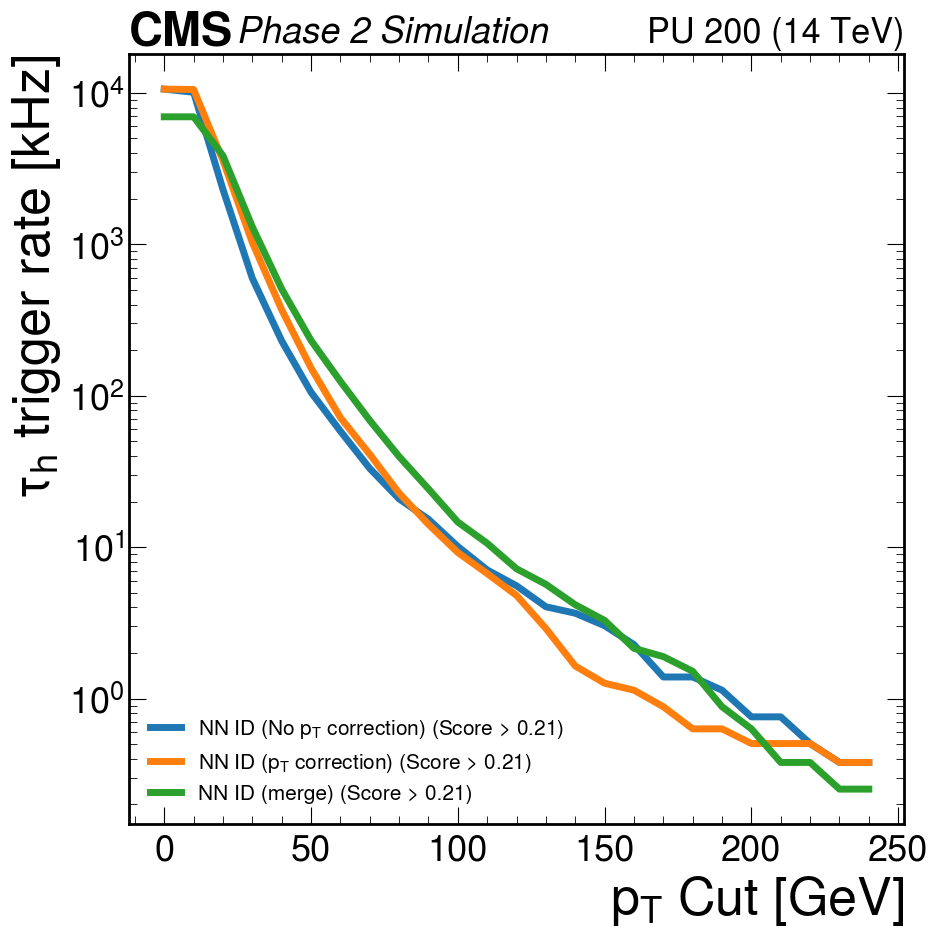

In [28]:
plt.plot(pt_cuts, minbias_rate_nn, label = r"NN ID (No $p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)
plt.plot(pt_cuts, minbias_rate_nn_corrected, label = r"NN ID ($p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)
plt.plot(pt_cuts, minbias_rate_nn_corrected_merge, label = r"NN ID (merge) (Score > {})".format(nn_cut), linewidth=5)
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.yscale('log')
plt.ylabel(r"$\tau_h$ trigger rate [kHz]")
plt.xlabel(r"$p_T$ Cut [GeV]")
plt.legend(loc = 'lower left',fontsize = 15)
plt.show()

-----

# Re-plotting the ROC curve

In [26]:
def prep_rate_data(ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(ModelNameID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    model_regress = load_model(ModelNameRegress)
    
    minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:
        bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
        sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

        sig_list_corrected.append(sig_pass/n_sig_event)
        bkg_list_corrected.append(bkg_pass/n_event)

    bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
    
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
    plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID ($p_T$ Correction)',linewidth=5)
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")

    plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
    plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

    plt.yscale('log')
    #plt.ylim([10e-2,10e+4])
    plt.legend(loc='best',fontsize=20)
    plt.show()
    
    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 494us/step


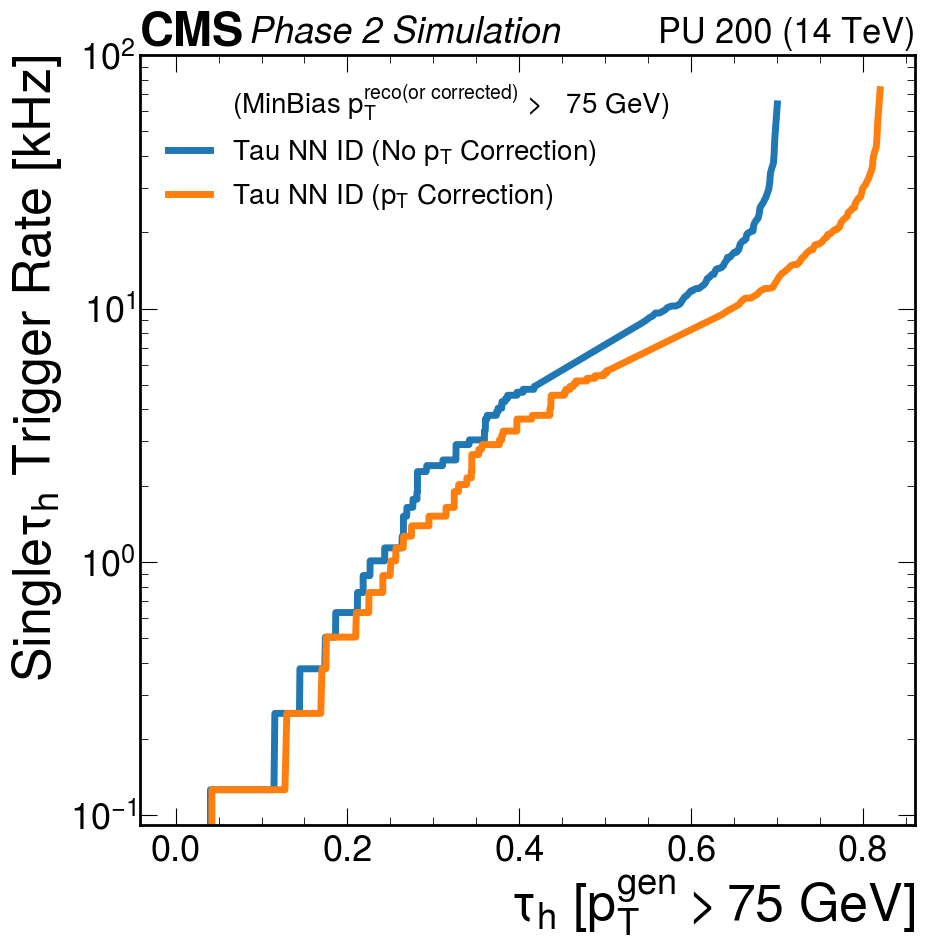

In [28]:
n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    '../models/pt_regress_v1_best.h5',
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)